In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
file_train_text = "../../data/training_text/training_text"
file_train_variant = "../../data/training_variants/training_variants"

In [3]:
train_text = pd.read_csv(file_train_text, sep = '\|\|')
train_text.index.name = "ID"
train_text.columns = ["Text"]

train_variant = pd.read_csv(file_train_variant)
train_variant.set_index("ID",inplace = True)

/home/ragou/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
train_variant[train_variant["Variation"].isin(["C396R", "H398Q", "Y371H", "K382E", "C381A"])]

,Gene,Variation,Class
ID,,,
8,CBL,Y371H,4
11,CBL,K382E,4
13,CBL,C381A,4
21,CBL,C396R,4


In [5]:
train_variant[train_variant["Variation"] == "Q249E"]

,Gene,Variation,Class
ID,,,
2,CBL,Q249E,2


In [6]:
train_text.loc[[6],]

,Text
ID,
6,Oncogenic mutations in the monomeric Casitas B...


In [7]:
gene_count = train_variant["Gene"].value_counts().loc[lambda x : x > 100].to_dict()

In [8]:
gene_class = train_variant[train_variant["Gene"].isin(gene_count.keys())]

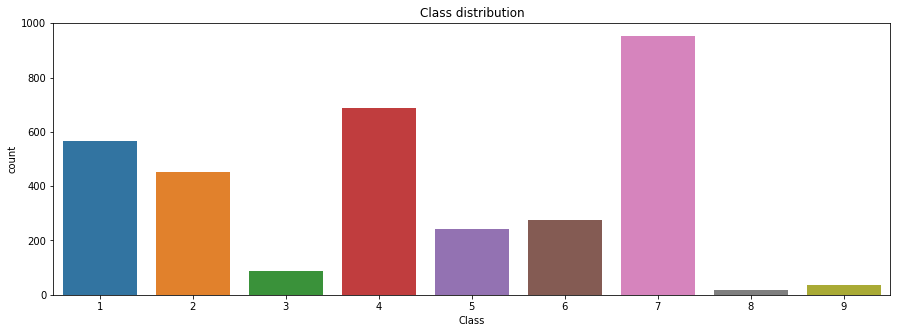

In [9]:
plt.figure(figsize=(15,5))
sns.countplot(x = train_variant["Class"])
plt.title("Class distribution")
plt.show()

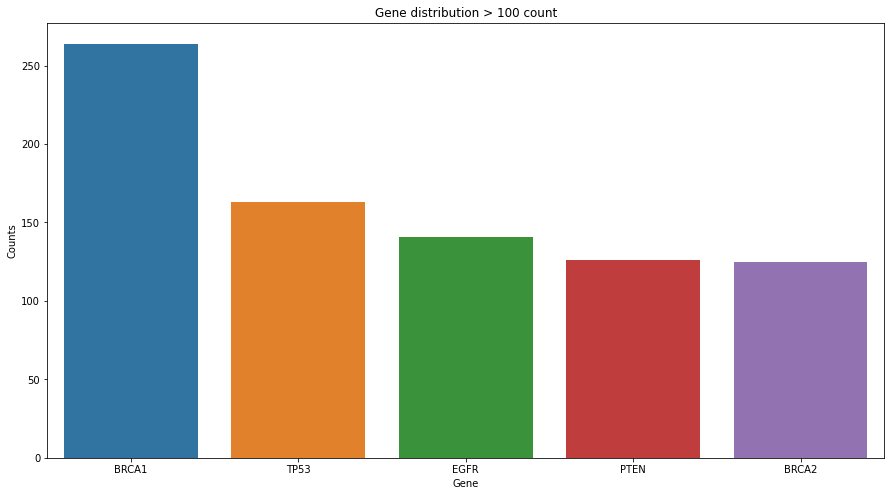

In [10]:
plt.figure(figsize=(15,8))

sns.barplot( x = list(gene_count.keys()), y = list(gene_count.values()))
plt.title("Gene distribution > 100 count")
plt.ylabel("Counts")
plt.xlabel("Gene")

plt.show()

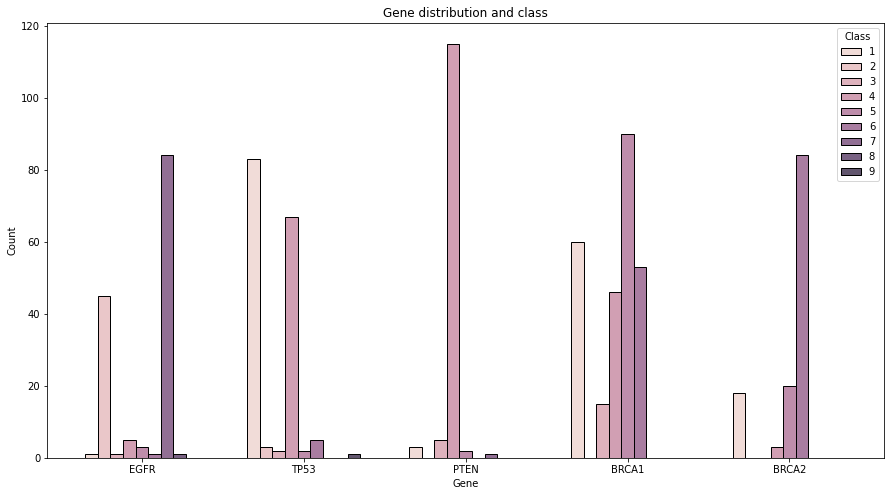

In [11]:
plt.figure(figsize=(15,8))
sns.histplot(data=train_variant[train_variant["Gene"].isin(gene_count.keys())],
             x="Gene", hue="Class", multiple="dodge", shrink=.7)
plt.title("Gene distribution and class")
plt.show()

In [12]:
train_variant.head(5)

,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


In [200]:
train_variant[train_variant["Gene"] == "RAD51"]

,Gene,Variation,Class
ID,,,


In [13]:
train_text.head(5)

,Text
ID,
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
amino_acid_dict = {'C' : 'CYS', 'D' : 'ASP', 'S' : 'SER', 'Q' : 'GLN', 'K' : 'LYS',
    'I' : 'ILE', 'P' : 'PRO', 'T' : 'THR', 'F' : 'PHE', 'N' : 'ASN', 
    'G' : 'GLY', 'H' : 'HIS', 'L' : 'LEU', 'R' : 'ARG', 'W' : 'TRP', 
    'A' : 'ALA', 'V' : 'VAL', 'E' : 'GLU', 'Y' : 'TYR', 'M' : 'MET'}

# Fonction pour la selection

## clean_text
Nettoie l'article, lower puis enlève les points qui pourrait nuire à la detection des phrases, (comme les "...", ou "fig.A")


## find_match
Va détecter la phrase qui contient le mot, puis prend 1 phrase avant et après (au total 3 phrase) (voir diapo)

In [8]:
def amino_three(amino):
    return amino_acid_dict[amino]
    
def decompose_variation(variation):
    decompose_aa_pos_aa = re.compile("([a-z]{1,})(\d+)([a-z]{1,})")
    list_variation = decompose_aa_pos_aa.search(variation)
    if list_variation:
        aa1 = list_variation.group(1)
        aa2 = list_variation.group(3)

        if len(aa1) + len(aa2) == 2:
            amino1 = amino_acid_dict[aa1.upper()].lower()
            position = list_variation.group(2)
            amino2 = amino_acid_dict[aa2.upper()].lower()
            return [amino1,position,amino2]
    return False

def decompose_fusion(variation):
    decompose_g1_g2_fusion = re.compile("(\w+)\s?(\?|-)\s?(\w+)\? fusion")
    list_variation = decompose_g1_g2_fusion.search(variation)
    if list_variation:
        gene1 = list_variation.group(1)
        gene2 = list_variation.group(3)
        print(gene1,gene2,variation, list_variation.group(0))
        return "(" + gene1 + "|" + gene2 + ")"
    return False
        
    

In [9]:
concatenate_data["Variation"].apply(lambda x: print(x,decompose_variation(x.lower())))

NameError: name 'concatenate_data' is not defined

In [15]:
def clean_text(article):
    dot3 = re.compile("[.]{2,}")
    fig = re.compile("fig[s]?\.")
    decimal = re.compile("\d+\.\d+")    
    etal = re.compile("et al\.")
    ie = re.compile("i.e.")
    inc = re.compile("inc.")
    mutation_point = re.compile("[p|c]\.")
    
    clean_article = article.lower()
    clean_article = dot3.sub(".", clean_article)
    clean_article = fig.sub("", clean_article)
    clean_article = decimal.sub("", clean_article)
    clean_article = etal.sub("", clean_article)
    clean_article = ie.sub("", clean_article)    
    clean_article = inc.sub("", clean_article)    
    clean_article = mutation_point.sub("", clean_article)    
    
    
    return clean_article

def join_tuple_string(strings_tuple):
    return ' '.join(strings_tuple)

def find_match(text, word):
    clean = clean_text(text)
    word = word.lower()
    target_sentence = "([^.]*{}[^.]*\.)".format(word)
    before_after_target = "([^.]*\.){0,1}"    
    match_exp = re.compile(before_after_target + target_sentence + before_after_target)
    match_text = match_exp.findall(clean)
    final_match = "".join(list(map(join_tuple_string, match_text)))
    return final_match

def extract_match(line):
    # Mettre celui qui consomme le moins en 1er --> ceux qui sont facile à faire sans trop de calcul !
    # 1er : best match
    # 2e ?
    
    
    # Cleaning text     
    text = clean_text(line["Text"])
    variation = line["Variation"].lower()
    gene = line["Gene"].lower()
    print(line.name)
    # Try first match with inital variation value
    # Quality score = 1 
    initial_match = find_match(text, variation)    
    if len(initial_match) != 0:
        print("First match ! ", variation)
        return initial_match, 1
    

    # Fusion of two genes
    # Quality score = 2
    if "fusion" in variation:
        fusion_gene = decompose_fusion(variation)
        if fusion_gene:
            match_fusion_gene = find_match(text, fusion_gene)
            if len(match_fusion_gene) != 0:
                print("Fusion gene1 | gene2", variation)
                return match_fusion_gene, 2

        # Try to match the word fusion at least..
        # Quality score 4 (bad)
        match_fusion = find_match(text,"fusion")
        if len(match_fusion) != 0:
            print("FUSION", variation)
            return match_fusion, 4
        
    aa_pos_aa = decompose_variation(variation)
    if aa_pos_aa :
        if len(aa_pos_aa) == 3:
            # If we success to split variation in 3 group --> aa1 pos aa2
            # Second try without the last amino acid --> y371
            match_variation_aa_pos = find_match(text, variation[:-1])
            if len(match_variation_aa_pos) != 0:
                print("y371 aa_pos", variation)
                
                return match_variation_aa_pos, 2

            # Third try with 3 letter code of amino acid --> tyr371ser
            match_aa_pos_aa = find_match(text, "".join(aa_pos_aa))
            if len(match_aa_pos_aa) != 0:
                print("aa_pos_aa", variation)
                return match_aa_pos_aa, 1
            
            # Try with 3 letter code without the last aa --> tyr371
            match_aa_pos = find_match(text, aa_pos_aa[0] + aa_pos_aa[1])
            if len(match_aa_pos) != 0:
                print("aa_pos", variation)
                
                return match_aa_pos,2
            
            # Match position only --> 371
            match_pos = find_match(text, aa_pos_aa[1])
            if len(match_pos) != 0:
                print("pos", variation)
                
                return match_pos,4
            
            # Match position around the real position --> 370 - 379
            match_pos_weak = find_match(text, aa_pos_aa[1][:-1] + "[0-9]")
            if len(match_pos_weak) != 0:
                print("pos weak", variation)
                
                return match_pos_weak,5
            
            
            
    return [],0



In [388]:
a = "165"
a[:-1] + "[0-9]"


'16[0-9]'

In [148]:
extract_match(concatenate_data.loc[19,:])

" transformed nih3t3 cells showed pi3 kinase-dependent activation of akt and the transformed phenotype was reverted by treatment with the pi3 kinase inhibitor ly294002 (supplementary  9).  when introduced into lin-\u2009sca1+\u2009c-kit+ (lsk) hspcs, c-cbl mutants (c-cbl(gln367pro) and c-cbl(tyr371ser)), as well as a mouse lymphoma-der oncogenic mutant (c-cbl(70z)), significantly promoted the replating capacity of these progenitors ( 2a).  because c-cbl negaty modulates tyroskinase signalling, and all c-cbl mutations, uding those previously reported13, 14, 15, 16, affected the critical domains for its enzymatic activity involved in this modulation, c-cbl was postulated to have a tumour suppressor function; loss-of-function could be a mechanism for the oncogenicity of these c-cbl mutants3, 5. if you requassistance to access this image, or to obtain a text description, please contact npg@nature. com a, prolonged replating capacity of lsk cells transduced with mutant c-cbl (c-cbl(gln367pr

# Exemple à la main juste pour tester

In [15]:
word_to_search = "FAM58A"

In [16]:
article = train_text.loc[0].values[0]

In [17]:
article.count(word_to_search)

34

In [498]:
pd.DataFrame([["klkmklm",1],['kk',2],["ar",5]])

,0,1
0,klkmklm,1
1,kk,2
2,ar,5


In [32]:
clean_match = find_match(article, word_to_search)

In [33]:
print("Before selection : total lenght {} and {} occurences of the word {}".format(
    len(article),article.count(word_to_search) , word_to_search))

print("After selection :  total lenght {} and {} occurences of the word {}".format(
    len(clean_match),clean_match.count(word_to_search.lower()), word_to_search))

Before selection : total lenght 39672 and 34 occurences of the word FAM58A
After selection :  total lenght 9214 and 34 occurences of the word FAM58A


In [11]:
concatenate_data = pd.merge(train_variant, train_text, on="ID").dropna()
concatenate_data

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...
3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...


In [16]:
clean_match_data = concatenate_data.apply(lambda x: extract_match(x), axis = 1)
clean_match = pd.DataFrame(list(clean_match_data), columns = ["Text","Score"])

0
1
First match !  w802*
2
First match !  q249e
3
First match !  n454d
4
First match !  l399v
5
First match !  v391i
6
First match !  v430m
7
First match !  deletion
8
First match !  y371h
9
First match !  c384r
10
First match !  p395a
11
First match !  k382e
12
First match !  r420q
13
First match !  c381a
14
First match !  p428l
15
First match !  d390y
16
17
First match !  q367p
18
First match !  m374v
19
aa_pos_aa y371s
20
First match !  h94y
21
First match !  c396r
22
First match !  g375p
23
First match !  s376f
24
First match !  p417a
25
First match !  h398y
26
First match !  s2g
27
First match !  y846c
28
First match !  c228t
29
First match !  h412y
30
First match !  h876q
31
First match !  promoter mutations
32
First match !  p704s
33
First match !  amplification
34
First match !  c250t
35
First match !  g1809r
36
First match !  g1809k
37
First match !  d1709e
38
First match !  d1709a
39
First match !  e1705a
40
First match !  d1810a
41
First match !  truncating mutations
42
Firs

First match !  r175c
388
First match !  r248w
389
First match !  s121a
390
First match !  y220s
391
First match !  p153h
392
First match !  r181c
393
First match !  r337c
394
First match !  k120n
395
First match !  g245d
396
First match !  r175h
397
First match !  r181l
398
First match !  g244s
399
pos s240r
400
First match !  r273c
401
First match !  e221q
402
First match !  q331h
403
First match !  y220c
404
First match !  r342p
405
First match !  c242f
406
First match !  c242s
407
y371 aa_pos c135s
408
First match !  m237k
409
aa_pos v197l
410
First match !  s121c
411
First match !  s241f
412
413
First match !  r248k
414
First match !  h214r
415
First match !  l330r
416
pos weak p151s
417
First match !  truncating mutations
418
First match !  r110l
419
First match !  c176f
420
First match !  h179y
421
First match !  c277r
422
First match !  l344r
423
First match !  r267q
424
First match !  r156h
425
First match !  d186a
426
First match !  c275s
427
First match !  e285k
428
429
First

First match !  l726i
742
First match !  h878y
743
First match !  exon 20 insertions
744
First match !  amplification
745
First match !  l755s
746
First match !  d821n
747
First match !  g309a
748
aa_pos_aa e265k
749
First match !  d769y
750
First match !  t798i
751
First match !  l755p
752
y371 aa_pos y1248f
753
First match !  p780l
754
First match !  v777l
755
First match !  s783p
756
First match !  d769a
757
First match !  c311r
758
759
First match !  d277h
760
First match !  r143q
761
First match !  g309e
762
First match !  e321g
763
First match !  l726f
764
First match !  v777m
765
First match !  y803n
766
First match !  n857s
767
First match !  d845a
768
769
First match !  s310y
770
First match !  v794m
771
772
First match !  s846i
773
First match !  a1131t
774
First match !  g284r
775
First match !  p262h
776
First match !  v714m
777
First match !  t389k
778
First match !  amplification
779
First match !  q809r
780
First match !  r669c
781
First match !  a232v
782
First match !  

1093
First match !  t1481fs
1094
1095
First match !  e1286v
1096
First match !  t779fs
1097
First match !  truncating mutations
1098
First match !  deletion
1099
First match !  a95d
1100
First match !  e685v
1101
First match !  c91s
1102
First match !  truncating mutations
1103
First match !  f170i
1104
First match !  i47f
1105
First match !  c91a
1106
First match !  f81v
1107
First match !  deletion
1108
First match !  s858r
1110
First match !  truncating mutations
1111
First match !  h492r
1112
First match !  y510c
1113
First match !  deletion
1114
First match !  l274p
1115
First match !  w183a
1116
First match !  l210r
1117
1118
1119
First match !  r970c
1120
y371 aa_pos y1003c
1121
1122
First match !  f1200i
1123
First match !  n375s
1124
aa_pos v1092i
1125
First match !  y1230c
1126
First match !  y1003f
1127
First match !  amplification
1128
1129
1130
First match !  d1010h
1131
1132
1133
First match !  overexpression
1134
First match !  y1003*
1135
First match !  y1235d
1136
1137

First match !  f102c
1449
First match !  m117i
1450
1451
First match !  r251q
1452
First match !  k517r
1453
First match !  e731k
1454
First match !  y375c
1455
First match !  k659n
1456
First match !  fusions
1457
First match !  t730s
1458
First match !  fgfr2-mgea5 fusion
1459
First match !  v755i
1460
First match !  g271e
1461
First match !  l770v
1462
First match !  r203c
1463
pos e565g
1464
First match !  fgfr2-ahcyl1 fusion
1465
First match !  a648t
1466
pos weak n549s
1467
First match !  p253r
1468
First match !  g701s
1469
First match !  t341p
1470
FUSION fgfr2?pphln1 fusion
1471
First match !  n549k
1472
First match !  s252w
1473
First match !  fgfr2-bicc1 fusion
1474
First match !  v248d
1475
First match !  k526e
1476
First match !  l617f
1477
First match !  i642v
1478
pos weak m535i
1479
pos weak k525e
1480
First match !  e636k
1481
FUSION fgfr2-tacc3 fusion
1482
FUSION fgfr2-kiaa1967 fusion
1483
1484
First match !  c278f
1485
First match !  a389t
1486
pos weak l617m
1487
14

First match !  s214c
1808
First match !  g322s
1809
First match !  t37a
1810
First match !  g17v
1811
aa_pos_aa g17e
1812
aa_pos_aa g14v
1813
First match !  e40q
1814
aa_pos_aa l57v
1815
First match !  r5q
1816
1817
First match !  t19n
1818
First match !  y42c
1819
First match !  e40t
1820
First match !  overexpression
1821
First match !  e40l
1822
First match !  g17a
1823
First match !  y34c
1824
First match !  e40w
1825
First match !  e40n
1826
1827
First match !  w257g
1828
y371 aa_pos s256w
1829
pos p179r
1830
aa_pos r183p
1831
First match !  r182w
1832
pos r258h
1833
First match !  s256f
1834
pos r258c
1835
pos p179l
1836
aa_pos r183g
1837
y371 aa_pos w257c
1838
aa_pos r183q
1839
First match !  deletion
1840
First match !  truncating mutations
1841
First match !  r1625c
1842
First match !  m1255i
1843
First match !  a1374v
1844
First match !  g1125a
1845
First match !  h114y
1846
First match !  p186s
1847
First match !  s270l
1848
First match !  r264c
1849
First match !  h284n
185

KeyboardInterrupt: 

In [507]:
clean_match

,Text,Score
0,"here, we deorphancdk10 by tifying cyclin m, th...",3
1,the c-cbl loh also posity correlated with egf...,1
2,the c-cbl loh also posity correlated with egf...,1
3,"most of the changes were novel, although 4 ca...",1
4,all mutations from the second group were pred...,1
...,...,...
3311,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1
3312,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,3
3313,lpxn is preferentially expressed in hematopoi...,1
3314,") conversely, mutations mapping to the first d...",1


# Explications du problème
Fonction poubelle juste pour voir ceux qui sont pas détectable --> len(match) == 0

Si ils sont pas détectable, c'est que le nom donné pour leurs variation sont pas dans l'article, donc je vérfie à la main sur le site https://regex101.com/r/lvQZIf/1 qui sert à visualiser les expressions régulières.
En copiant collant tout l'article, je regarde comment je peux détecter la variation avec un autre nom ducoup, comme le nom de base ne marche pas.

Par exemple Id = 19, y371s n'est pas dans l'article mais il y est sous la forme tyr371ser.

Cet regexpr ne marche pas (le texte est en minuscule) -> `([^.]*\.){0,1}([^.]*y371s[^.]*\.)([^.]*\.){0,2}`

Mais celle la marchera -> `([^.]*\.){0,1}([^.]*tyr371ser[^.]*\.)([^.]*\.){0,2}` (ça donne 3 match sur le site pour l'article id = 19)

(pour les regex, il faut juste changer le nom au milieu après `*` et avant `[^.]`)

Autre exemple, ID = 102, mutation r922* qui n'est mentionné sous aucunes formes, ni même la position 922. Mais, il y a des mots qui peuvent faire penser à cette mutation du genre "nonsense mutations" car l'étoile (\*) veut dire que r922 est devenu un codon stop, donc c'est une mutation non sens. Faudrait voir si je peux convertir ces mutations en mot pour faciliter la détection, ou utiliser un champ lexical.


Donc là, j'essaie de faire plus ou moins au cas par cas (pas tous, y en a 880...) pour déterminer des groupes de variations indétectable pour revoir la détection.
Par exemple, pour les variations de type `y371s`, je peux prendre `y371`, ou tout simplement `371` qui peuvent détecter la variation dans certain cas.


Par contre, pour ceux où y a vraiment pas d'infos dans l'article avec la variation, du genre `t1365m` ID = 44; je sais pas quoi faire d'eux :)
Car la position 1365 n'est même pas mentionné dans l'article, donc je vois pas comment détecter les infos liées à cette mutation...

Soit je garde l'article entier, soit je prend le nom du gène pour la détection, mais le pb avec ça, c'est que ducoup tout ceux qui sont indétectables de ce gène là, auront les mêmes lignes de détecté car je détecterai uniquement en utilisant le nom du gène, donc y aura pas de différences entre eux même si la variation diffère.




## Ne lance pas la cellule juste en bas, ça prend un certain temps et de toute façon, tu as déjà la sortie avec tout ceux qui ne marchent pas.

La sortie est de la forme : 
`variation | id | len(article_original) | len(match)`

Certaines variations sont des mots complets du genre `truncating mutations`, un peu relou pour la détection, ce qu'on pourrait faire, c'est utiliser des mots qui ressemble à truncating grace à des méthodes de traitements de texte qui va prendre que le préfix par exemple et automatiser ça pour les mots

In [ ]:
def check_line(x):
    extract = extract_match(x)
    score = extract[1]
    if score == 0:
        print(x["Variation"].lower(), x.name, len(x["Text"]))

        
concatenate_data.apply(lambda x : check_line(x) , axis = 1)

# Variable ID pour faciliter le print des deux cellules suivantes pour choper le text, la variation et le gene d'un ID et les copier coller sur le site regex

Pour la détection, je teste juste avec le nom de la variation, puis vraiment si y a rien, je regarde du coté du nom du gène

In [553]:
ID = 3311

In [555]:
concatenate_data.loc[ID,"Text"].lower()

"the aml1/evi-1 chimeric gene is generated by the t(3;21)(q26;q22) translocation and plays a pivotal role in progression of hematopoietic stem cell malignancies such as chronic myelocytic leukemia and myelodysplastic syndrome. in aml1/evi-1, an n-terminal half of aml1 including a runt homology domain is fused to the entire zinc-finger evi-1 protein. aml1 is essential for hematopoietic cell development in fetal liver and its lineage-specific differentiation in adult. in contrast, evi-1 is barely expressed in normal hematopoietic cells, but it is overexpressed in chronic myelocytic leukemia in blastic crisis and myelodysplastic syndrome-derived leukemia. there are at least four mechanisms identified in aml1/evi-1 fusion protein that possibly lead into malignant transformation of hematopoietic stem cells. firstly, aml1/evi-1 exerts dominant-negative effects over aml1-induced transcriptional activation. although target genes repressed by aml1/evi-1 are still not known, binding competition 

In [554]:
print(concatenate_data.loc[ID,"Variation"].lower(),
concatenate_data.loc[ID,"Gene"].lower())

runx1-evi1 fusion runx1


In [252]:
import numpy as np
CBL = train_variant[train_variant["Gene"] == "RUNX1"]
article_cbl = train_text.loc[CBL.index,]

CBL.to_csv("cbl.txt")
dtf = pd.merge(pd.DataFrame(clean_article_CBL.index), clean_article_CBL, on ="ID")
np.savetxt("cbl_clean_article.txt",dtf, fmt = "%d||%s", header= ",".join(dtf.columns), comments='')

In [534]:
new_data = pd.merge(train_variant,clean_match, on = "ID")

In [552]:
new_data[new_data["Score"] == 1]

,Gene,Variation,Class,Text,Score
ID,,,,,
1,CBL,W802*,2,the c-cbl loh also posity correlated with egf...,1
2,CBL,Q249E,2,the c-cbl loh also posity correlated with egf...,1
3,CBL,N454D,3,"most of the changes were novel, although 4 ca...",1
4,CBL,L399V,4,all mutations from the second group were pred...,1
5,CBL,V391I,4,all mutations from the second group were pred...,1
...,...,...,...,...,...
3310,RUNX1,Amplification,7,this truncated protein conta the rhd but not ...,1
3311,RUNX1,RUNX1-EVI1 Fusion,4,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1
3313,RUNX1,H78Q,4,lpxn is preferentially expressed in hematopoi...,1


In [588]:
count = new_data[new_data["Score"] == 1].apply(lambda line: check_line(line), axis = 1)

truncating mutations 1110 0
deletion 1113 0
l274p 1114 0
w183a 1115 0
x1007_splice 1118 0
v1188l 1121 0
f1200i 1122 0
v1092i 1124 0
y1003f 1126 0
x963_splice 1129 0
x1009_splice 1132 0
overexpression 1133 0
y1003* 1134 0
h1094l 1136 0
m1250t 1142 0
h1106d 1144 0
y1230h 1145 0
n1100y 1149 0
s3660l 1154 0
truncating mutations 1156 0
truncating mutations 1163 0
i31m 1165 0
m1043i 1170 0
g106v 1172 0
d350g 1173 0
e545q 1174 0
n1068fs*4 1177 0
n1044k 1179 0
t1025s 1182 0
q60k 1185 0
e545k 1187 0
e365k 1188 0
e81k 1189 0
h701p 1193 0
p449_l455del 1199 0
p449t 1201 0
a1020v 1203 0
q546r 1206 0
e579k 1207 0
d1029y 1208 0
g106_r108del 1210 0
e453a 1214 0
c378r 1215 0
i391m 1217 0
fusions 1224 0
d1067y 1226 0
e1051k 1228 0
d1067a 1229 0
y53h 1236 0
p123m 1237 0
fusions 1241 0
amplification 1242 0
yap1-fam118b fusion 1244 0
e218* 1249 0
i559_d560insdkrmns 1251 0
n564d 1252 0
w237_y242del 1253 0
x582_splice 1257 0
k459_s460delinsn 1262 0
r348* 1265 0
r262t 1266 0
e439del 1268 0
k376n 1270 0
amplif

p1859r 2547 0
d1778n 2553 0
w1837r 2556 0
v1833e 2557 0
p1806a 2558 0
d1733g 2568 0
s1297del 2571 0
l1764p 2574 0
g1770v 2576 0
a1752v 2577 0
g1763v 2579 0
d1739y 2582 0
e1660g 2583 0
s1715r 2584 0
m1628v 2586 0
v1838e 2592 0
g1738e 2595 0
v1809f 2598 0
m1008i 2602 0
e1282v 2603 0
e1214k 2604 0
v1665m 2605 0
r1589h 2608 0
n1819s 2610 0
v1808a 2611 0
p1771l 2616 0
r1758g 2624 0
l1267s 2628 0
e143k 2629 0
t1720a 2630 0
q1826h 2643 0
s1164i 2645 0
q1756c 2650 0
r841q 2651 0
m1663k 2656 0
s1715n 2657 0
e1250k 2660 0
s1613c 2661 0
l668f 2662 0
p1614s 2663 0
v1378i 2667 0
t1685i 2669 0
s1473p 2673 0
e1346k 2675 0
r133h 2676 0
a1843t 2677 0
d1778g 2678 0
t599_v600insv 2685 0
l485f 2686 0
l485_p490del 2687 0
l485_p490delinsf 2688 0
a598v 2689 0
i326v 2690 0
q201h 2691 0
a246p 2693 0
g596v 2694 0
v600r 2695 0
v471f 2696 0
t529m 2697 0
g478c 2699 0
t529i 2702 0
k483e 2706 0
r506_k507insvlr 2707 0
r671q 2711 0
v487_p492delinsa 2716 0
p61braf 2718 0
agk-braf fusion 2720 0
t599dup 2721 0
s151a 2722

In [578]:
index_hacker = count[count == 0].index
index_hacker

Int64Index([ 290,  677,  697,  748,  946,  953,  966,  970, 1074, 1109,
            ...
            3303, 3304, 3305, 3306, 3308, 3310, 3311, 3313, 3314, 3315],
           dtype='int64', name='ID', length=1445)

In [584]:
concatenate_data.loc[290,"Text"].lower()

"follicular lymphoma, the most common indolent non-hodgkin lymphoma, remains a significant clinical burden, as the majority of affected individuals undergo multiple relapses and eventually develop resistance to standard therapies. furthermore, in a subset of individuals, follicular lymphoma transforms into the more aggressive diffuse large b cell lymphoma (dlbcl), with this transformation associated with poor clinical outcomes2, 3, 4. recent genetic profiling and case studies of donor-derived follicular lymphoma following stem cell transplantation suggest the putative existence of a 'long-lived' tumor-initiating progenitor cell compartment from which successive disease events occur5, 6, 7, 8. an in-depth characterization and chronicling of the underlying genetic events from follicular lymphoma to transformed follicular lymphoma will serve as a guide in the development of effective targeted therapies. to address this need, we conducted whole-genome or whole-exome sequencing of sequentia

In [581]:
new_data.loc[290,]

Gene                                                  HIST1H1C
Variation                                                S102F
Class                                                        1
Text          most of the histone h1 alterations were misse...
Score                                                        1
Name: 290, dtype: object